# Homework 2: Evaluating Paired Functions
*Sean Steinle*

### Contents
0. [Imports, Data Loading](#Imports,-Data-Loading)
1. [Preprocessing F and G](#Preprocessing-F-and-G)
2. [Error Metrics for F and G](#Error-Metrics-for-F-and-G)

In [60]:
df["subject"]

0           1
1           1
2           1
3           1
4           1
         ... 
150145    150
150146    150
150147    150
150148    150
150149    150
Name: subject, Length: 150150, dtype: int64

## Imports, Data Loading

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp

In [2]:
path = "data/homework_02-data.csv"
df = pd.read_csv(path)

In [3]:
df.head()

,subject,x,f,g
0,1,0.000,-1.171990,-0.342031
1,1,0.001,-1.082194,-0.327248
2,1,0.002,-0.952844,-0.297205
3,1,0.003,-0.793758,-0.263112
4,1,0.004,-0.614753,-0.226987


## Preprocessing F and G

In [50]:
#helper functions for the main preprocessing function. simple, mainly for abstraction/readability
def scale(x: float, l: float, h: float):
    """Scale value between the minimum, l, and maximum, h.
    Pass in l and h so we don't need to recalculate min and max so often.
    Inspired by: https://stackoverflow.com/questions/18380419/normalization-to-bring-in-the-range-of-0-1
    """
    return (x-l)/(h-l)

def warp(x: int, B: tuple):
    """Warp function that partially defines f and g."""
    b1, b2, b3 = B
    return (exp(b1)*x + exp(b2)*x**exp(b3))/(exp(b1)+exp(b2))

In [104]:
#the core preprocessing function
def preprocess(subject: int, data: pd.DataFrame):
    """Preprocesses data by selecting subject i from the data, scaling f_i and g_i to [0,1], and returning a
    function to evaluate f(x) and g(x_tilde).
    Returns a function that will evaluate f and g at many x for a given tuple of betas.
    """
    #select subject data
    subject_df = df[df["subject"] == subject]
    
    #expand x as int
    x_int = subject_df["x"].map(lambda x: int(x*1000))
    
    #scale function values to [0,1]
    F = subject_df["f"]
    l = np.min(F)
    h = np.max(F)
    f_scaled = F.map(lambda f: scale(f, l, h)).tolist()

    #now scale g
    G = subject_df["g"]
    l = np.min(G)
    h = np.max(G)
    g_scaled = G.map(lambda g: scale(g, l, h)).tolist()
    
    def preprocessor(betas: tuple):
        """This function is returned from the larger preprocess function. 
        It returns scaled f values and scaled and warped g values.
        """
        if len(betas) != 3:
            raise ValueError("You must specify exactly 3 betas to estimate g.")

        G = [warp(g_scaled[x],betas) for x in x_int]
        
        return f_scaled,G #returns scaled, evaluated f and g
        
    return preprocessor

**Testing Our Function Factory**

To test that our function factory is working correctly, we can perform a few quick tests:
1. We can evaluate G for the beta set (1,100,0). This set of betas essentially turns the warp function into an identity function (as B2 trends towards infinity). We can see this phenomenon by plotting our scaled f and scaled and warped g values against each other. They are nearly identical.
2. We can evaluate F and G for all samples (from 1:150) without error.
3. We should ensure if we pass more or less than 3 betas, there is an informative error.

Text(0, 0.5, 'F(x) and G(w(x,B))')

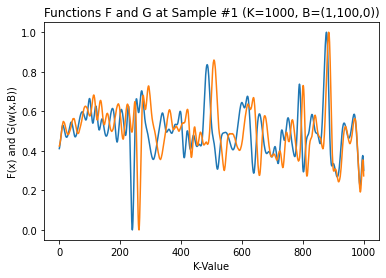

In [105]:
#Test 1: specify g to be an identity function

#generate values for f and g for candidate 1 with identity-value betas
sample1_preprocessor = preprocess(1,df)
f,g = sample1_preprocessor((1,100,0))

#plot f and g
plt.plot(range(0,1001,1),f)
plt.plot(range(0,1001,1),g)
plt.title("Functions F and G at Sample #1 (K=1000, B=(1,100,0))")
plt.xlabel("K-Value")
plt.ylabel("F(x) and G(w(x,B))")

In [106]:
#Test 2: We can evaluate F and G for all samples i
preprocessors = [preprocess(i,df) for i in range(1,151,1)]
function_pairs = [p((1,100,0)) for p in preprocessors]
F,G = function_pairs[0] #for sample 1
assert len(F) == 1001
assert len(G) == 1001

In [107]:
#Test 3: More or less than 3 betas raises error
p = preprocess(1,df)
try:
    f,g = p((1,100))
except:
    print("Caught value error!")

Caught value error!


## Error Metrics for F and G

TODO: shouldn't we be passing in the dataset into this function? doesn't say that in the instructions...

In [188]:
#TODO: in retrospect, I should have written just one objective function and done the switch logic inside of it. this is too much replicated code
def l2_metric(B: tuple, preprocess_function):
    """Calculates the L2 error for a given set of beta values."""
    errors = []
    function_pairs = [preprocess_function(sample_i,df)(B) for sample_i in range(1,151,1)] #evaluate F,G wrt this set of betas for each candidate
    for sample_i,(F,G) in enumerate(function_pairs): #now consider each sample
        error = sum([(F[x]-G[x])**2 for x in range(len(F))]) #calculate the loss at each point, sum
        errors.append(error) #append this sample's total error to the list of error
    return errors

def huber_rho(t: float, c: float):
    """Helper function for huber_metric which calculates the rho value."""
    if abs(t) <= c:
        return (t**2)/2
    else:
        return c*(abs(t)-(c/2))
    
def huber_metric(B: tuple, preprocess_function, c: float):
    """Calculates the Huber error for a given set of beta values."""
    errors = []
    function_pairs = [preprocess_function(sample_i,df)(B) for sample_i in range(1,151,1)] #evaluate F,G wrt this set of betas for each candidate
    for sample_i,(F,G) in enumerate(function_pairs): #now consider each sample
        error = sum([huber_rho((F[x]-G[x]),c) for x in range(len(F))]) #calculate the loss at each point, sum
        errors.append(error) #append this sample's total error to the list of error
    return errors

def tukey_rho(t: float, c: float):
    """Helper function for tukey_metric which calculates the rho value."""
    if abs(t) <= c:
        return 1-((1-(t/c)**2)**3)
    else:
        return 1
    
def tukey_metric(B: tuple, preprocess_function, c: float):
    """Calculates the Tukey error for a given set of beta values."""
    errors = []
    function_pairs = [preprocess_function(sample_i,df)(B) for sample_i in range(1,151,1)] #evaluate F,G wrt this set of betas for each candidate
    for sample_i,(F,G) in enumerate(function_pairs): #now consider each sample
        error = sum([tukey_rho((F[x]-G[x]),c) for x in range(len(F))]) #calculate the loss at each point, sum
        errors.append(error) #append this sample's total error to the list of error
    return errors

In [189]:
def calculate_error(B: tuple, preprocess_function, error_metric: str, cutoff: float):
    if error_metric == "l2":
        return l2_metric(B, preprocess_function)
    elif error_metric == "huber":
        return huber_metric(B, preprocess_function, cutoff)
    elif error_metric == "tukey":
        return tukey_metric(B, preprocess_function, cutoff)
    else:
        raise ValueError(f"{error_metric} is not a supported metric type. Try l2, huber, or tukey.")

In [192]:
betaset1_error = calculate_error((1,500,0), preprocess, "tukey", 1)
betaset1_error

[67.34575317303891,
 39.66960281811339,
 104.1859957266836,
 107.21913651543905,
 71.58607600441574,
 16.60141682411065,
 53.593103705261576,
 42.89392336926948,
 183.67202483638403,
 60.36636353018066,
 119.3937064360529,
 165.23348477436477,
 12.361364360145318,
 87.26644871951582,
 62.6197968822893,
 90.89714866928625,
 32.23751676528872,
 92.35535025564621,
 155.7463768307114,
 118.611530781259,
 154.88476483071938,
 101.85591605283469,
 143.43941152988288,
 88.57479703069815,
 168.7317421584221,
 74.68482370499262,
 65.9894178919924,
 29.62279596515796,
 3.0340392545966877,
 118.87886462176684,
 101.77101763819901,
 9.056462935211545,
 112.92445160265292,
 167.8792218704819,
 138.89444263550268,
 75.7839278744872,
 108.54677066510213,
 110.3428946309831,
 22.22274164346883,
 76.4476910939442,
 1.1858415185379902,
 89.57543143894503,
 53.8035205810671,
 97.33955266023835,
 99.82664584686721,
 85.52124797818202,
 141.77224525298757,
 54.76268652597569,
 82.27563487917914,
 122.04744

In [175]:
#hm, I would think that betaset2 would dominate betaset1 here.
betaset1_error = calculate_error((1,500,0), preprocess, "l2", 0)
betaset2_error = calculate_error((1,5,0), preprocess, "l2", 0)
deltas = []
for sample_i in range(len(betaset1_error)):
    deltas.append(betaset2_error[sample_i] - betaset1_error[sample_i])
deltas

[3.552713678800501e-15,
 -1.7763568394002505e-15,
 -7.105427357601002e-15,
 7.105427357601002e-15,
 -7.105427357601002e-15,
 1.7763568394002505e-15,
 0.0,
 -3.552713678800501e-15,
 -1.4210854715202004e-14,
 0.0,
 -7.105427357601002e-15,
 0.0,
 2.6645352591003757e-15,
 7.105427357601002e-15,
 0.0,
 0.0,
 -3.552713678800501e-15,
 7.105427357601002e-15,
 7.105427357601002e-15,
 0.0,
 -1.4210854715202004e-14,
 -7.105427357601002e-15,
 0.0,
 -1.4210854715202004e-14,
 -1.4210854715202004e-14,
 0.0,
 -3.552713678800501e-15,
 -3.552713678800501e-15,
 8.881784197001252e-16,
 -2.1316282072803006e-14,
 0.0,
 -2.6645352591003757e-15,
 -7.105427357601002e-15,
 0.0,
 -1.4210854715202004e-14,
 0.0,
 -7.105427357601002e-15,
 7.105427357601002e-15,
 0.0,
 0.0,
 1.6653345369377348e-16,
 -7.105427357601002e-15,
 -1.4210854715202004e-14,
 0.0,
 -1.4210854715202004e-14,
 7.105427357601002e-15,
 7.105427357601002e-15,
 3.552713678800501e-15,
 -7.105427357601002e-15,
 -1.4210854715202004e-14,
 0.0,
 0.0,
 7.